# 使用注意力机制的seq2seq
我们在seq2seq机器翻译中，设计了一个基于两个循环神经网络的编码器-解码器架构，具体来说，循环神经网络编码器将长度可变的序列转换为固定形状的上下文变量，然后循环神经网络解码器根据生成的词元和上下文变量按词元生成输出（目标）序列词元。在每个解码步骤中使用编码*相同*的上下文变量，然而，并非所有输入（源）词元都对解码某个词元都有用，有什么方法能改变上下文变量呢？

Bahdanau等人提出了一个没有严格单向对齐限制的可微注意力模型 :cite:`Bahdanau.Cho.Bengio.2014`。在预测词元时，如果不是所有输入词元都相关，模型将仅对齐（或参与）输入序列中与当前预测相关的部分。这是通过将上下文变量视为注意力集中的输出来实现的。

## 模型
下面描述的Bahdanau注意力模型遵循seq2seq中的相同符号表达。这个新的基于注意力的模型与原来的seq2seq中的模型相同，只不过上下文变量$\mathbf{c}$在任何解码时间步$t'$都会被$\mathbf{c}_{t'}$替换。
假设输入序列中有$T$个词元，解码时间步$t'$的上下文变量是注意力集中的输出：

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

其中，时间步$t' - 1$时的解码器隐状态$\mathbf{s}_{t' - 1}$是查询，编码器隐状态$\mathbf{h}_t$既是键，也是值，注意力权重$\alpha$是使用 :eqref:`eq_attn-scoring-alpha`所定义的加性注意力打分函数计算的。

下图描述了Bahdanau注意力的架构。

![一个带有Bahdanau注意力的循环神经网络编码器-解码器模型](./seq2seq-attention-details.svg)

:label:`fig_s2s_attention_details`

## 加性注意力

In [21]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout):
        super(AdditiveAttention, self).__init__()
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        # 输入queries: （batch_size, num_queries, qurey_size）
        # 输入keys：（batch_size, num_keys, key_size）
        # 输入values:(batch_size, num_value, value_size)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 输出quries：（batch_size, num_quries, num_hiddens）
        # 输出keys：（batch_size, num_keys, num_hiddens）
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hiddens)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = d2l.masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

## 定义编码器-解码器

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [22]:
class Seq2SeqEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0.1):
        super(Seq2SeqEncoder, self).__init__()
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [23]:
class Seq2SeqAttentionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super(Seq2SeqAttentionDecoder, self).__init__()
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)  # （key_size, query_size, num_hiddens, dropout）
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens):
        # outputs的形状为(num_steps，batch_size，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [24]:
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, enc_valid_lens):
        enc_outputs = self.encoder(enc_X)
        dec_state = self.decoder.init_state(enc_outputs, enc_valid_lens)
        return self.decoder(dec_X, dec_state)

例子：

In [25]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)

In [26]:
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 训练

In [8]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs = 0.005, 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

loss 0.019, 3044.0 tokens/sec on cuda


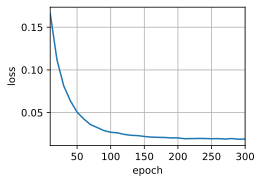

In [27]:
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测

模型训练后，我们用它[**将几个英语句子翻译成法语**]并计算它们的BLEU分数。

In [17]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, 
                        num_steps, device, save_attention_weights=True):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [18]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il court .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000
